In [305]:
import numpy as np
import control
from control.matlab import *
import matplotlib.pyplot as plt

In [306]:
#ts = 0.01
#num = [2.8771]
#den = [1, -1.7938, 0.79391025]
#G = tf( num,den, ts)
G=tf( [1] , [ 1, 3, 2] )

In [307]:
G

TransferFunction(array([1]), array([1, 3, 2]))

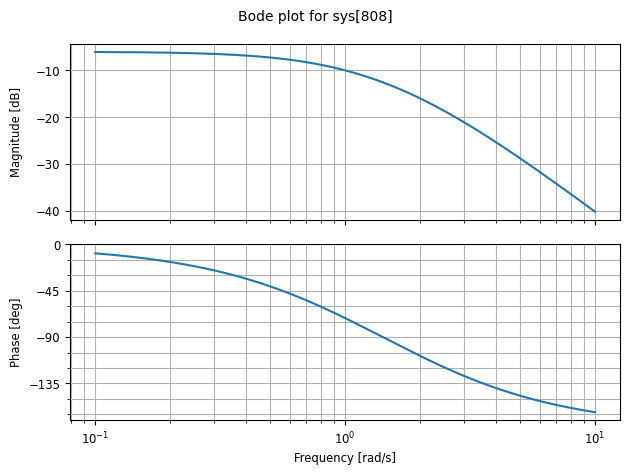

In [308]:
bode(G)
plt.show()

In [309]:
ts = 0.01
T = 20
t = np.arange(0, T, ts)
u = np.random.normal(0, 10, t.shape)

C:\Users\Paolo\Documents\GitHub\sysid-transformers-control\venv\lib\site-packages\control\timeresp.py:1003: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(


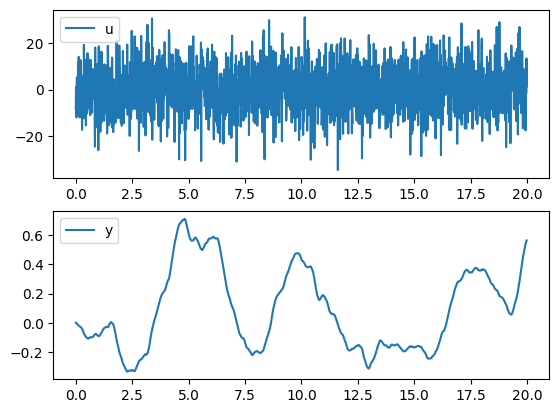

In [321]:
y, t, _ = lsim(G, u, t)
plt.subplot(211)
plt.plot(t, u, label="u")
plt.legend()
plt.subplot(212)
plt.plot(t, y, label="y")
plt.legend()

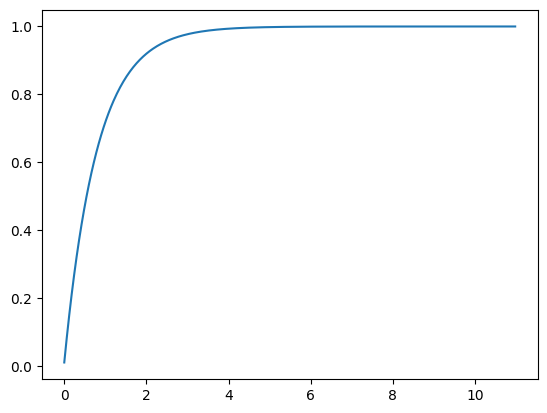

In [311]:
# VRFT
s = tf('s')
tau = 5 # s
M = 1/(1 + (tau/(2*np.pi))*s)
M = M*(1 + 1e-2*(tau/(2*np.pi))*s) # add a high freq zero for inversion
T_cl = tau + 0.5
t_cl = np.arange(0, T_cl, ts)
y_d, _ = step(M, 2*t_cl)
plt.plot(2*t_cl, y_d)

In [312]:
# vrft
r_v = lsim(M**(-1), y, t)[0]
e_v = r_v - y

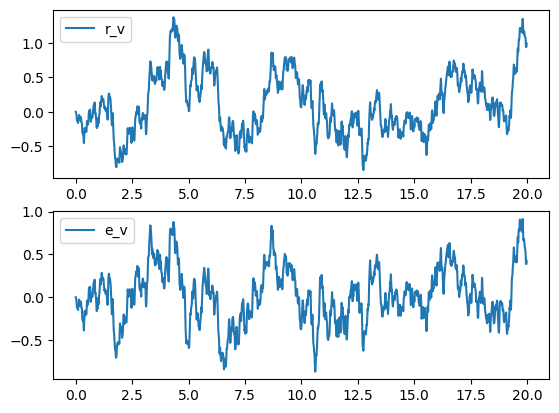

In [313]:
plt.subplot(211)
plt.plot(t, r_v, label="r_v")
plt.legend()
plt.subplot(212)
plt.plot(t, e_v, label="e_v")
plt.legend()

In [314]:
B=[tf([1],[1],ts),
   tf(ts*np.array([1, 1]),2*np.array([1, -1]),ts),
   tf(np.array([2, -2]),ts*np.array([3, -1]),ts)]

In [315]:
import cvxpy as cp
theta = cp.Variable(3)
u_theta = theta[0]*lsim(B[0], e_v, t)[0] + theta[1]*lsim(B[1], e_v, t)[0] + theta[2]*lsim(B[2], e_v, t)[0]

In [316]:
cost = 1/len(u) * cp.sum_squares(u - u_theta)
prob = cp.Problem(cp.Minimize(cost))
prob.solve()
theta_sol = theta.value

In [317]:
print(theta_sol)

[0.8295276  1.09991278 0.36816771]


In [318]:
C = theta_sol[0]*B[0] + theta_sol[1]*B[1] + theta_sol[2]*B[2]

In [319]:
#C = 0.0061*B[0] + 0.00037804*B[1]

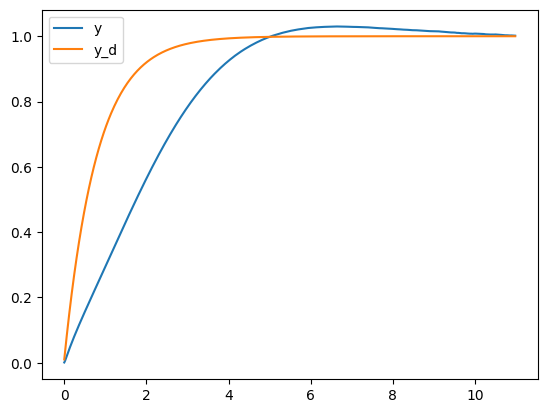

In [320]:
G = c2d(G, ts, 'tustin')
F = C*G/(1 + C*G)
y_cl, _ = step(F, 2*t_cl)
plt.plot(2*t_cl, y_cl, label='y')
plt.plot(2*t_cl, y_d, label='y_d')
plt.legend()
plt.show()